# FINAL PROJECT - DEEP LEARNING PROJECT - “Spam/Ham messages detection and filtering” - BILSTM


## Preliminary steps

### Preliminary step 1: General Setup 

In [ ]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras-tuner 
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installati

In [ ]:
import pandas as pd
import re
import string
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns


from  matplotlib import pyplot as plt

from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model
from keras_tuner.tuners import RandomSearch

from sklearn.feature_extraction import _stop_words
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score,classification_report
from sklearn.metrics.pairwise import cosine_similarity


### Preliminary step 2: Connection with Google Drive for upload our dataset 


In [ ]:
"""
Authenticate and create the PyDrive client
"""
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Project steps

### Collecting data (Data acquisition)

In [ ]:
df = pd.read_csv("drive/MyDrive/final_report_deeplearnig_PRDL_MLLB/progetto_nostro/spam_dataset.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

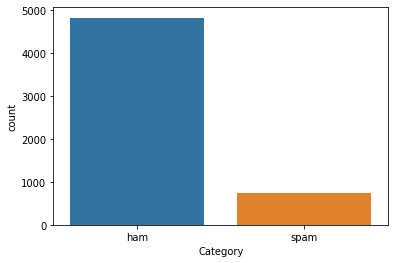

In [ ]:
sns.countplot(x=df['Category'])

####**Rebalancing of the dataset:**

In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced

,Category,Message,spam
1939,ham,Excellent! Are you ready to moan and scream in...,0
2531,ham,So the sun is anti sleep medicine.,0
5165,ham,Ü still got lessons? Ü in sch?,0
1111,ham,Ok ill tell the company,0
1298,ham,"K so am I, how much for an 8th? Fifty?",0
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,1
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1


### Preparing the data (Data pre-processing) + Building datasets (Data splitting and balancing)

#### **Splitting of the dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
X_train.head(4)

968     What do u want when i come back?.a beautiful n...
1939    Excellent! Are you ready to moan and scream in...
5503    Perhaps * is much easy give your account ident...
4196    Double mins and txts 4 6months FREE Bluetooth ...
Name: Message, dtype: object

#### **BERT model to get embedding vectors**

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

**Example of functioning of BERT**

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
# Get embeding vectors for few sample words.

e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

Compare them using cosine similarity: Values near to 1 means they are similar. 0 means they are very different. In fact, comparing "banana" and "grapes" you get 0.99 similarity because they both are fruits

In [ ]:
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

### Choosing the best model (Model building)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# create the model

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

### Training the model (Model training)



In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 507s 14s/step - loss: 0.3191 - accuracy: 0.9071 - precision: 0.8972 - recall: 0.9196
Epoch 2/10
35/35 [==============================] - 503s 14s/step - loss: 0.3030 - accuracy: 0.9018 - precision: 0.8879 - recall: 0.9196
Epoch 3/10
35/35 [==============================] - 501s 14s/step - loss: 0.2885 - accuracy: 0.9036 - precision: 0.8979 - recall: 0.9107
Epoch 4/10
35/35 [==============================] - 504s 14s/step - loss: 0.2798 - accuracy: 0.9080 - precision: 0.9002 - recall: 0.9179
Epoch 5/10
35/35 [==============================] - 502s 14s/step - loss: 0.2638 - accuracy: 0.9187 - precision: 0.9064 - recall: 0.9339
Epoch 6/10
35/35 [==============================] - 504s 14s/step - loss: 0.2650 - accuracy: 0.9107 - precision: 0.9049 - recall: 0.9179
Epoch 7/10
35/35 [==============================] - 504s 14s/step - loss: 0.2512 - accuracy: 0.9152 - precision: 0.9115 - recall: 0.9196
Epoch 8/10
35/35 [=======================

### Testing & Evaluating the model (Performance evaluation)


In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 169s 14s/step - loss: 0.2463 - accuracy: 0.9225 - precision: 0.9702 - recall: 0.8717


[0.24632814526557922,
 0.9224599003791809,
 0.9702380895614624,
 0.8716577291488647]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 169s 14s/step


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

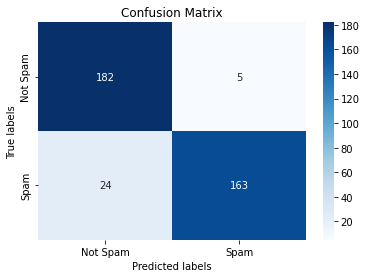

In [ ]:
cm = confusion_matrix(y_test, y_predicted)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [ ]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.88      0.97      0.93       187
           1       0.97      0.87      0.92       187

    accuracy                           0.92       374
   macro avg       0.93      0.92      0.92       374
weighted avg       0.93      0.92      0.92       374



### Interpreting the model results (Deployment)

In [ ]:
messages = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(messages)

1/1 [==============================] - 2s 2s/step


array([[0.7071214 ],
       [0.83132833],
       [0.71343154],
       [0.07517006],
       [0.02546445]], dtype=float32)